# Strategy:

Main strategy is to create plots with as much as possible information of user behaviour in each room, then stitch them together as one image. Also create additional plot with as much features encoded to individual users as well.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Change default style of matplotlib, seaborn
plt.style.use('seaborn')
sns.set_style('whitegrid')

# Change color pallette of seaborn, matplotlib
sns.set_palette('Set2')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set2.colors)

In [3]:
# Set max columns to 30
pd.set_option('display.max_columns', 30)

In [4]:
train = pd.read_csv('data/train.csv')
targets = pd.read_csv('data/train_labels.csv')

targets['question'] = targets['session_id'].apply(lambda x: int(x.split('_')[1].replace('q', '')))
targets['session_id'] = targets['session_id'].apply(lambda x: int(x.split('_')[0]))

In [5]:
train.head(5)

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


In [6]:
# How many rooms each user has visited
train.groupby('session_id')['room_fqid'].nunique().value_counts()

19    23560
18        2
Name: room_fqid, dtype: int64

In [7]:
# Some users did not access all 19 rooms, drop them
train = train[train['session_id'].isin(train.groupby('session_id')['room_fqid'].nunique()[train.groupby('session_id')['room_fqid'].nunique() == 19].index)]

In [8]:
# How many users reached each level
pd.DataFrame(train.groupby('level')['session_id'].nunique() / train.groupby('level')['session_id'].nunique().max()).T 

level,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
session_id,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.976231,1.0,1.0,1.0,1.0,0.999321,0.999703,1.0


There are some optional levels, we will not deal with them, when drawing picture, will just leave blank.

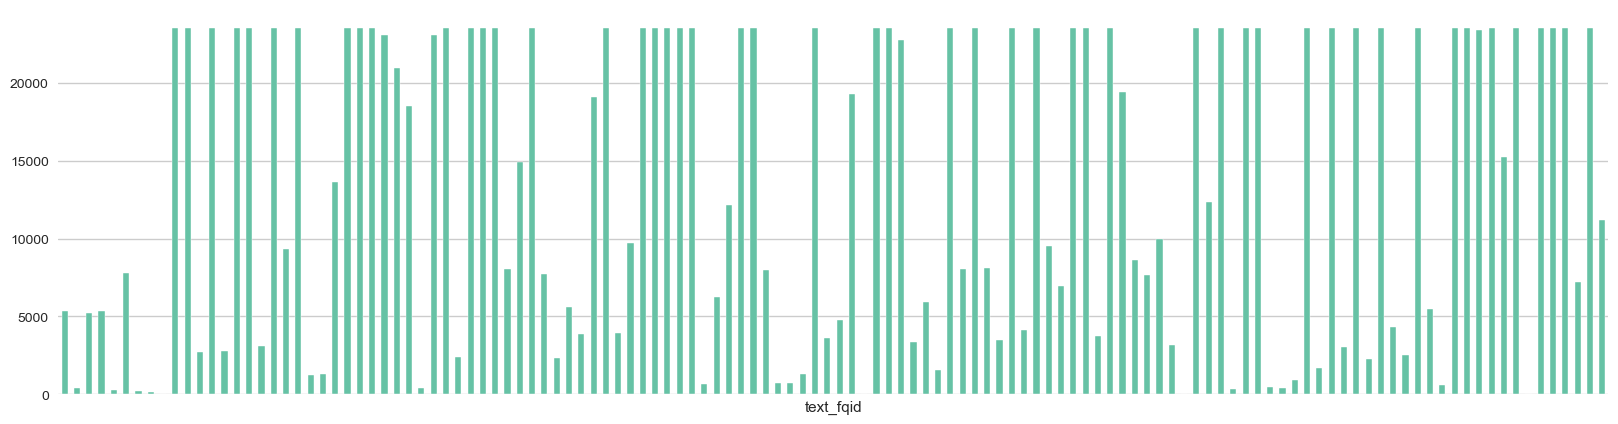

In [9]:
# How many users reached each text prompt
text_prompts = pd.DataFrame(train.groupby('text_fqid')['session_id'].nunique())

# plot prompt frequency, hide x axis labels
text_prompts.plot(kind='bar', figsize=(20, 5), legend=False)
plt.xticks([])
plt.show()

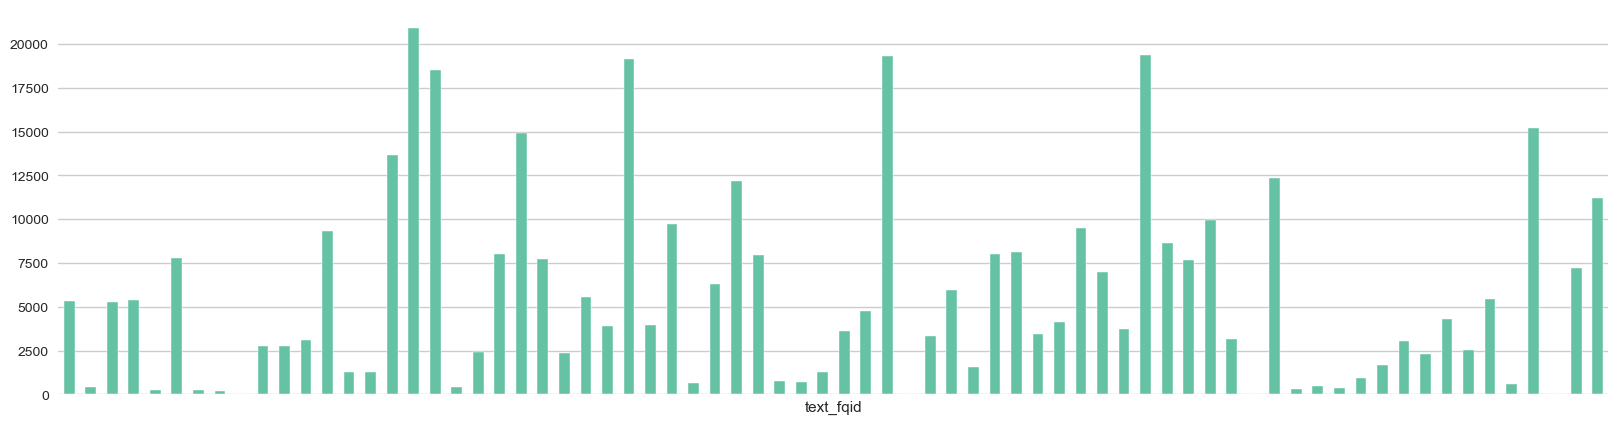

In [10]:
prompts_to_drop = text_prompts[text_prompts['session_id'] > 22000].index # will set to NA later on train

text_prompts = text_prompts.drop(prompts_to_drop)

# plot prompt frequency, hide x axis labels
text_prompts.plot(kind='bar', figsize=(20, 5), legend=False)
plt.xticks([])
plt.show() 

# Might be a good candidate for a feature, rarity of prompt accessed

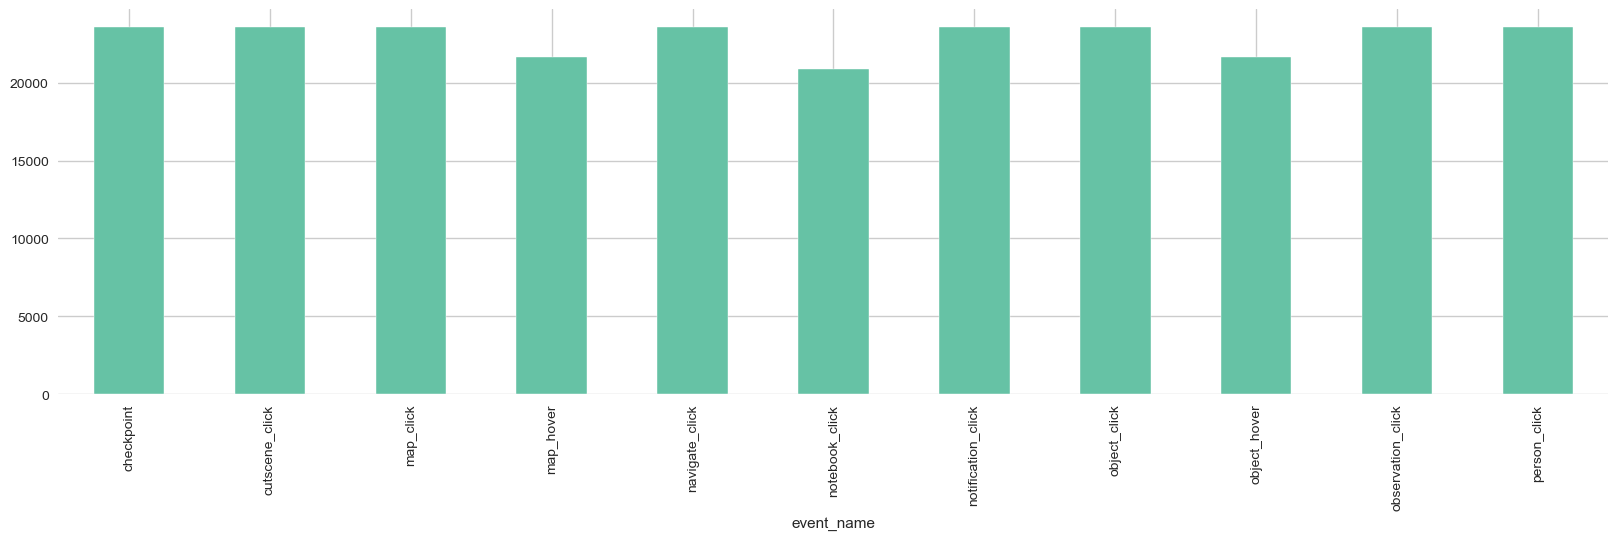

In [11]:
# How many users reached each event_name
event_names = pd.DataFrame(train.groupby('event_name')['session_id'].nunique())

# plot event_name frequency, hide x axis labels
event_names.plot(kind='bar', figsize=(20, 5), legend=False)
plt.show() # Each event name is reached by a similiar number of users


In [12]:
# Na value percentages in train by column
train.isna().sum() / train.shape[0]


session_id        0.000000
index             0.000000
elapsed_time      0.000000
event_name        0.000000
name              0.000000
level             0.000000
page              0.978531
room_coor_x       0.078841
room_coor_y       0.078841
screen_coor_x     0.078841
screen_coor_y     0.078841
hover_duration    0.923860
text              0.634291
fqid              0.314654
room_fqid         0.000000
text_fqid         0.634287
fullscreen        0.000000
hq                0.000000
music             0.000000
level_group       0.000000
dtype: float64

In [13]:
# Reverse enginnering session_id to get year, month, weekday, hour, minute

train["year"] = train["session_id"].apply(lambda x: int(str(x)[:2])).astype(np.uint8)
train["month"] = train["session_id"].apply(lambda x: int(str(x)[2:4]) + 1).astype(np.uint8)
train["weekday"] = train["session_id"].apply(lambda x: int(str(x)[4:6])).astype(np.uint8)
train["hour"] = train["session_id"].apply(lambda x: int(str(x)[6:8])).astype(np.uint8)
train["minute"] = train["session_id"].apply(lambda x: int(str(x)[8:10])).astype(np.uint8)

# could be useful to segment user types, maybe players that play late are more likely to answer incorrectly, etc.

### Interesting reads:
https://www.kaggle.com/code/chrisqiu/0-681-pytorch-using-only-1-column
https://www.kaggle.com/code/abaojiang/lb-0-694-tconv-with-4-features-training-part

Elapsed time seem to be one of the most important features. Maybe add additional plot to that? Or find a way to standardize date in other way for all events.

### Screen coordinate idea:

We can guess the user's screen resolution, and make an assumption on family's income, might be correlated with results.

## API requirement:
Api will load data in level segments, so we should train at least 3 different models for 0-4 segment, etc.